In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

PATH_TO_DATA = "/home/shared/DARPA/patched_data/patch_size_256_patch_overlap_0_legend_size_256/training"

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, bottleneck=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        elif bottleneck:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 4, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels//2, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [4]:
class DoubleUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super(DoubleUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        factor = 2 if bilinear else 1
            
        self.inc = DoubleConv(n_channels, 8)
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.down4 = Down(64, 128 // factor)
        self.up1 = Up(256, 64 // factor, bilinear, bottleneck=True)
        self.up2 = Up(64, 32 // factor, bilinear)
        self.up3 = Up(32, 16 // factor, bilinear)
        self.up4 = Up(16, 8, bilinear)
        self.outc = OutConv(8, n_classes)
    
    def encoder(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        return x1, x2, x3, x4, x5
    
    def forward(self, map_patch, label):
        x1, x2, x3, x4, x5 = self.encoder(map_patch)
        label_emb = self.encoder(label)[-1]
        x_cat = torch.cat((x5, label_emb), axis=1)
        x = self.up1(x_cat, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [5]:
class MapLoader(Dataset):
    def __init__(self, PATH_TO_DATA, label_transform, map_transform, seg_transform):
        self.label_transforms = label_transform
        self.map_transforms = map_transform
        self.seg_transforms = seg_transform
        self.path_to_map = os.path.join(PATH_TO_DATA, "map_patches")
        self.path_to_labels = os.path.join(PATH_TO_DATA, "labels")
        self.path_to_segs = os.path.join(PATH_TO_DATA, "seg_patches")
        self.filenames = os.listdir(self.path_to_map)
        
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        file = self.filenames[idx]
        path_to_map_file = os.path.join(self.path_to_map, file)
        path_to_seg_file = os.path.join(self.path_to_segs, file)
        path_to_label_file = os.path.join(self.path_to_labels, file)
        
        map_patch = Image.open(path_to_map_file)
        seg_patch = Image.open(path_to_seg_file)
        label = Image.open(path_to_label_file)
        
        return map_patch, seg_patch, label
        

In [36]:
map_mean = torch.tensor([0.7677, 0.7403, 0.6487])
map_std = torch.tensor([0.2415, 0.2356, 0.2564])
label_mean = torch.tensor([0.8048, 0.7714, 0.6715])
label_std = torch.tensor([0.2528, 0.2472, 0.2757])

map_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(map_mean, map_std)
])

lab_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(map_mean, map_std)
])

seg_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

dataset = MapLoader(PATH_TO_DATA, label_transform=lab_transform, map_transform=map_transform, seg_transform=seg_transform)
lengths = [int(len(dataset) * 0.95), len(dataset) - int(len(dataset) * 0.95)]
trainset, testset = random_split(dataset, lengths, generator=torch.Generator().manual_seed(42))

model = DoubleUNet()
params = torch.load("map_unet.pt", map_location=torch.device('cpu'))
new_state_dict = OrderedDict()

for key, value in params.items():
    key = key.replace("module.", "")
    new_state_dict[key] = value
    
model.load_state_dict(new_state_dict)
model.eval()
print("Keys Matched")
model

Keys Matched


DoubleUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

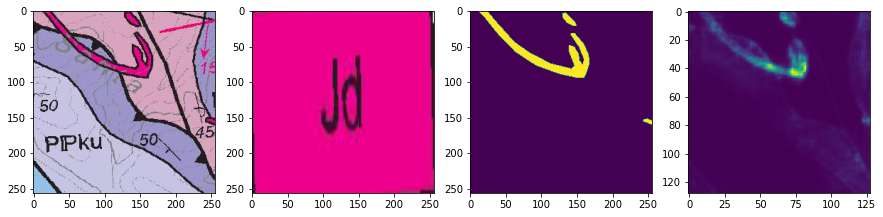

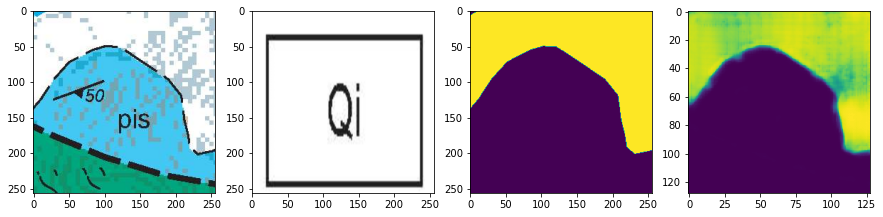

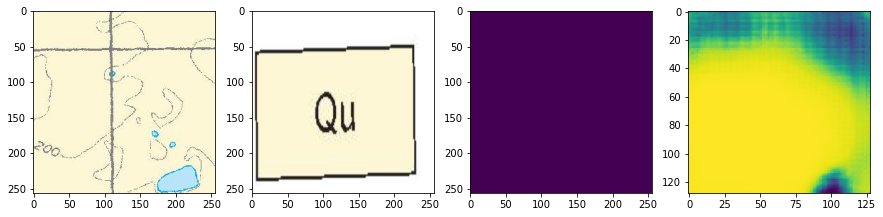

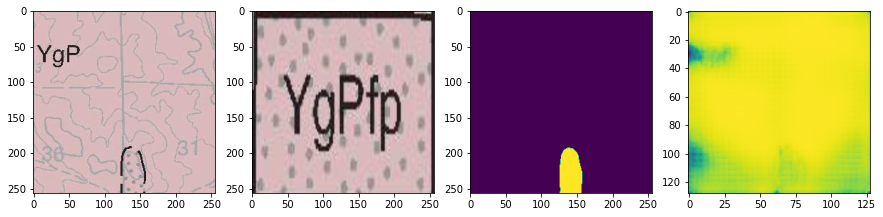

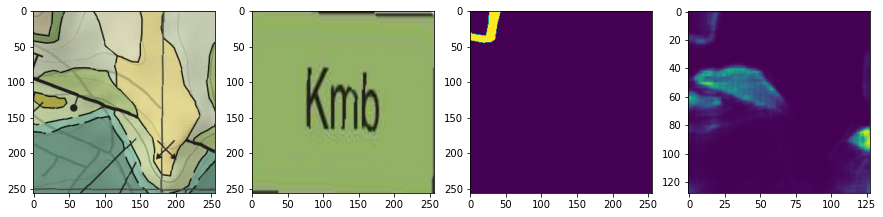

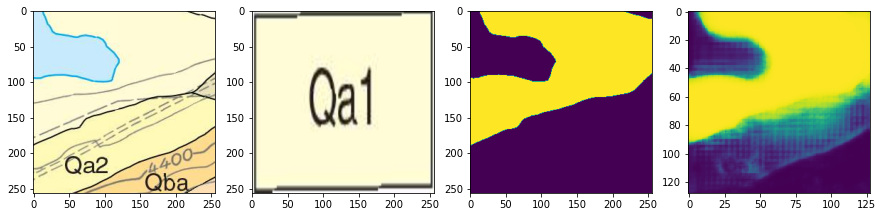

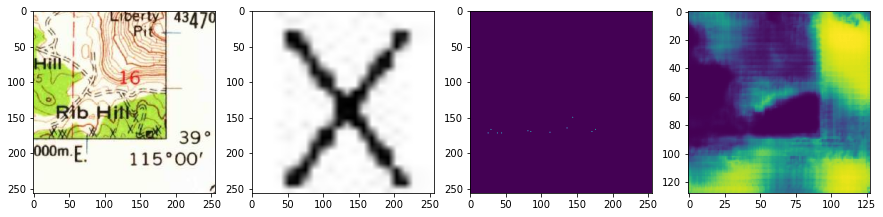

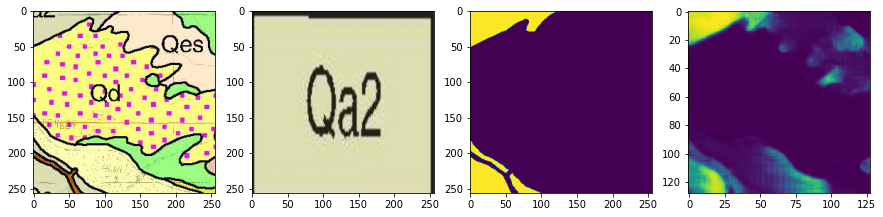

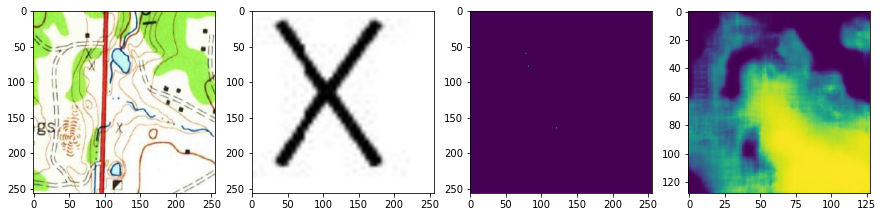

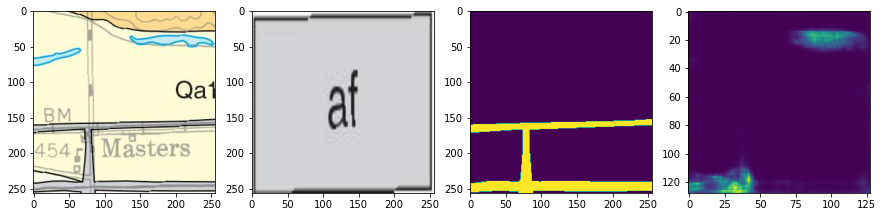

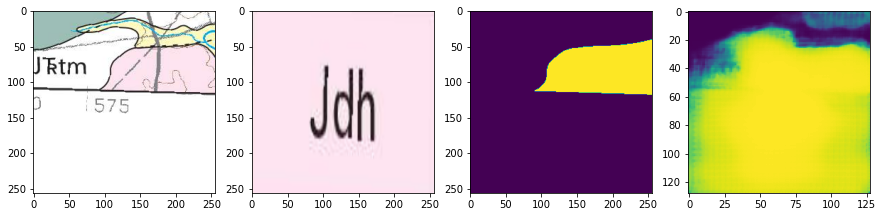

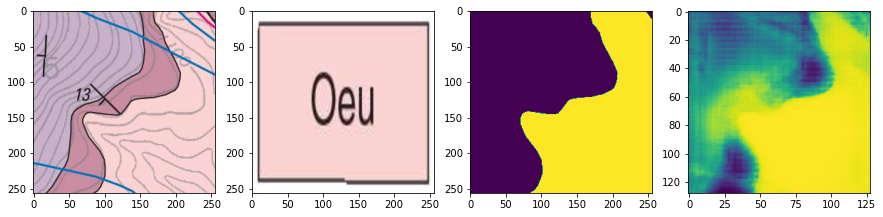

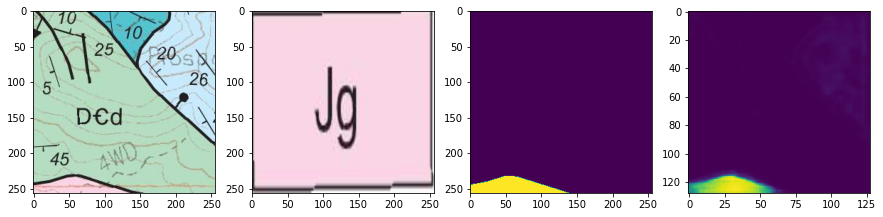

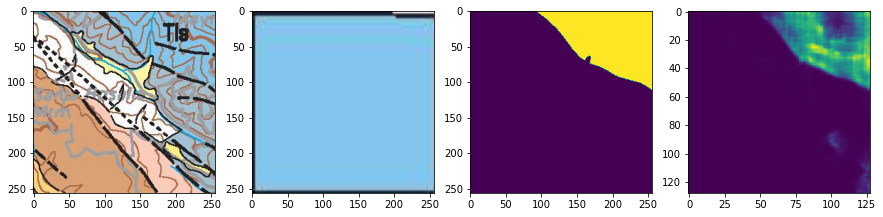

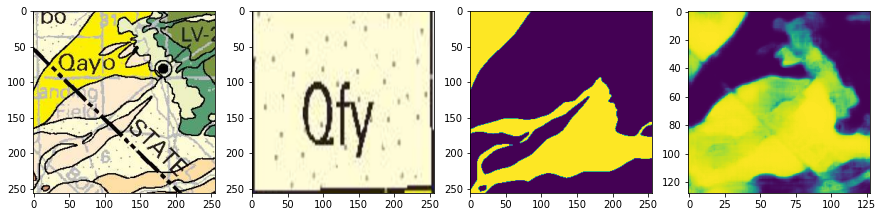

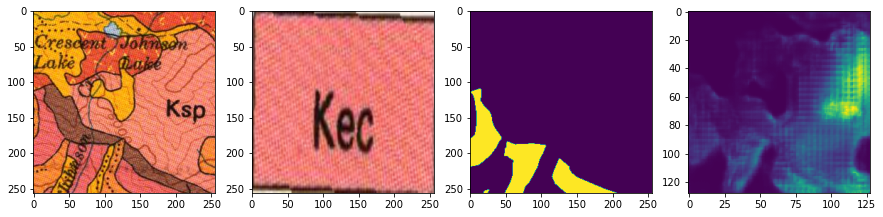

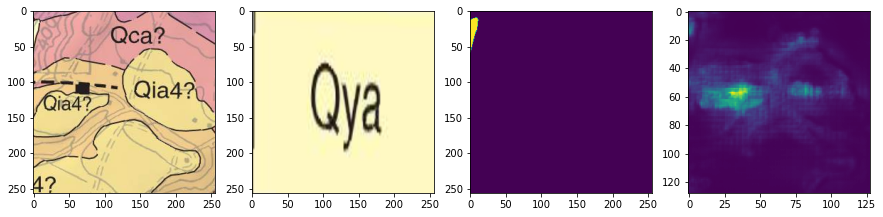

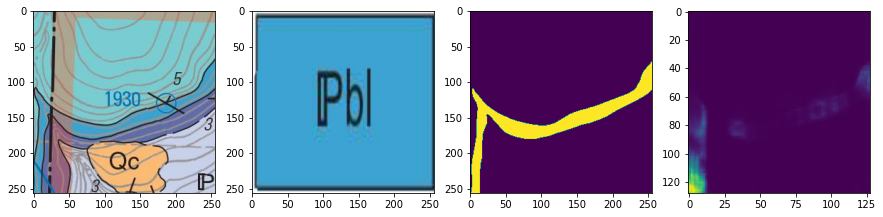

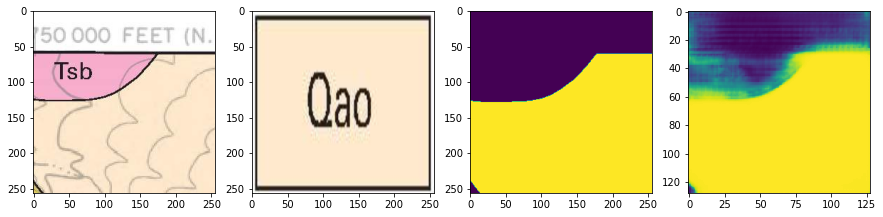

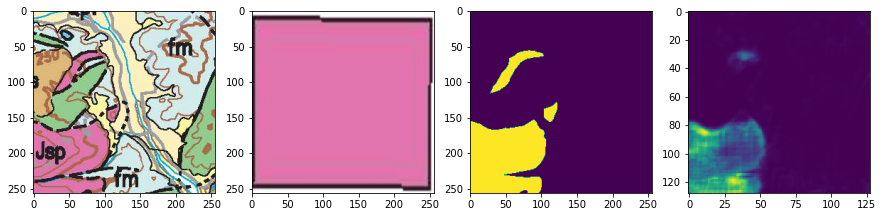

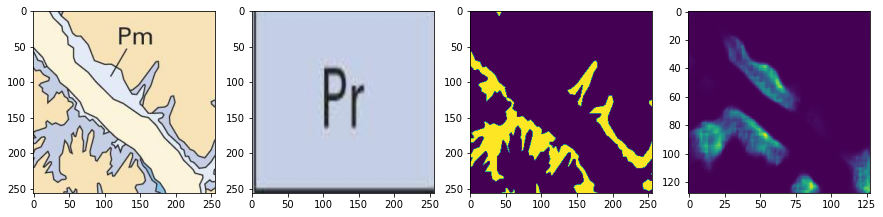

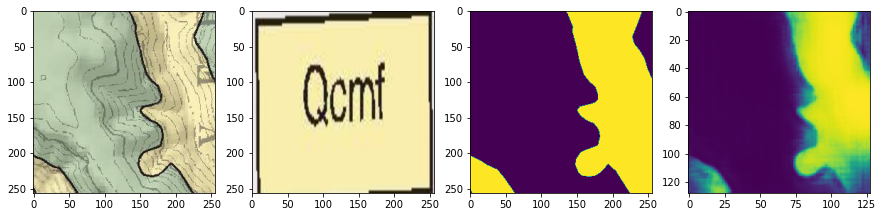

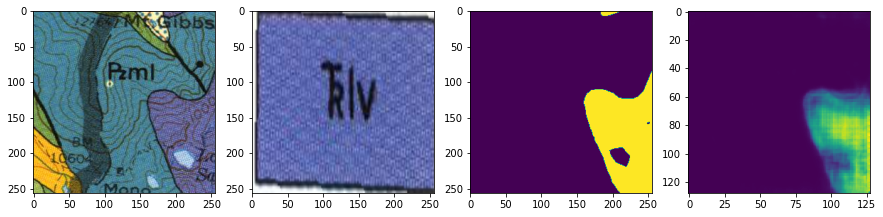

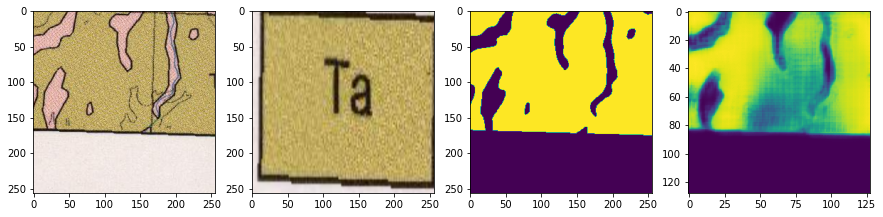

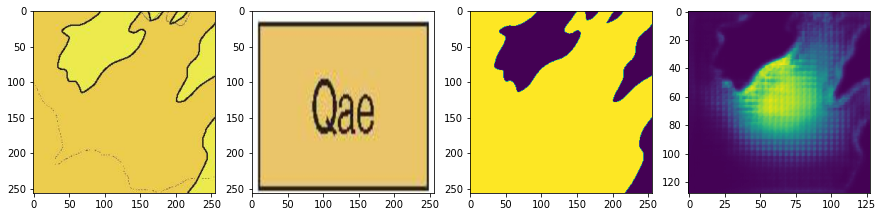

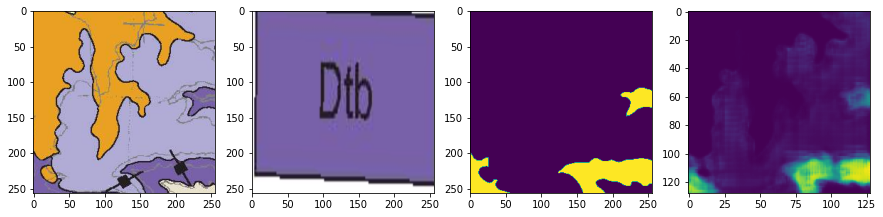

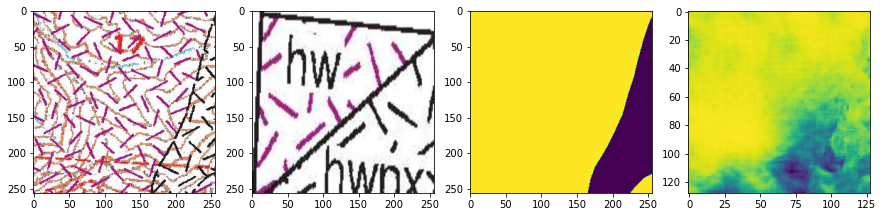

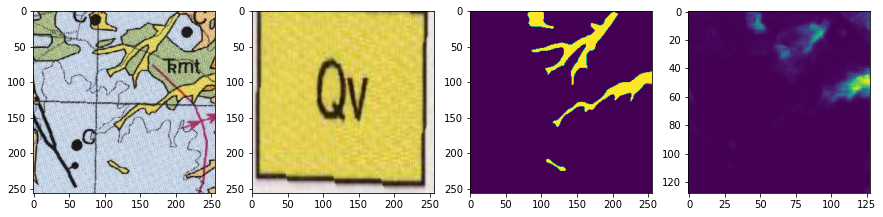

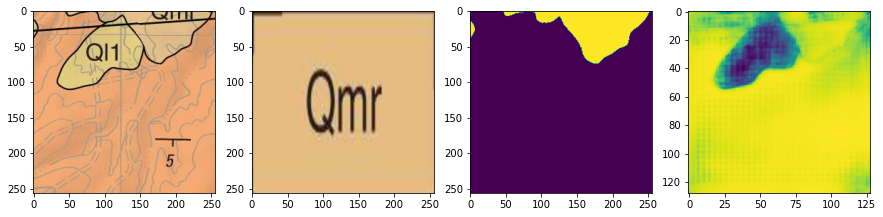

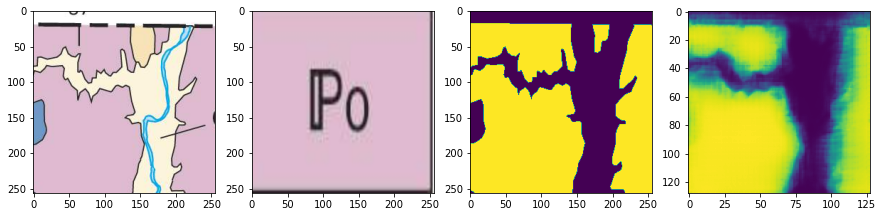

In [35]:
counter = 0
for map_patch, seg_patch, label in dataset:
    map_patch_transform = map_transform(map_patch).unsqueeze(0)
    label_patch_transform = lab_transform(label).unsqueeze(0)
    
    pred_seg = model.forward(map_patch_transform, label_patch_transform)
    pred_seg = torch.sigmoid(pred_seg)
    pred_seg = pred_seg.squeeze().detach().numpy()

    
    plt.figure(figsize=(15,15))
    plt.subplot(1, 4, 1)
    plt.imshow(map_patch)

    plt.subplot(1, 4, 2)
    plt.imshow(label)

    plt.subplot(1, 4, 3)
    plt.imshow(seg_patch)

    plt.subplot(1, 4, 4)
    plt.imshow(pred_seg)

    plt.show()
    counter +=1 
    
    if counter == 30:
        break